In [3]:
import sys
import os

import numpy as np
import matplotlib.pyplot as plt
from gym_multigrid.envs import MARL_env 

from matplotlib.colors import ListedColormap
from collections import deque
import random
import copy
from collections import OrderedDict
import pandas as pd
import time

seed = 0
np.random.seed(seed)
random.seed(seed)

In [4]:
class MultiAgentEnvWrapper:
    """
    Wrapper class for CustomMultiAgentEnv that distinguishes between training and testing phases
    """
    
    def __init__(self, is_testing=False, width=10, height=10, max_steps=100, seed=None,
                 agent_positions=None, goal_positions=None, walls=None):
        self.is_testing = is_testing
        self.width = width
        self.height = height
        self.max_steps = max_steps
        self.seed = seed
        self.envs = []  # stores all environments created
        self.initial_states = []
        
        if agent_positions is None or goal_positions is None:
            raise ValueError("agent_positions and goal_positions must be provided")
        
        # Training mode: one env per agent/goal pair
        if not is_testing:
            for agent_pos, goal_pos in zip(agent_positions, goal_positions):
                agents = [{"start": agent_pos, "goal": goal_pos}]
                env = MARL_env.CustomMultiAgentEnv(
                    width=width,
                    height=height,
                    max_steps=max_steps,
                    seed=seed,
                    agents=agents
                )
                
                # Add walls if specified
                if walls:
                    for wall_x, wall_y in walls:
                        env.add_wall(wall_x, wall_y)
                
                self.envs.append(env)
                self.initial_states.append(env.reset()[0])  # Get first agent's observation
        
        # Test mode: one env with all agents and goals
        else:
            agents = [{"start": start, "goal": goal} for start, goal in zip(agent_positions, goal_positions)]
            env = MARL_env.CustomMultiAgentEnv(
                width=width,
                height=height,
                max_steps=max_steps,
                seed=seed,
                agents=agents
            )
            
            # Add walls if specified
            if walls:
                for wall_x, wall_y in walls:
                    env.add_wall(wall_x, wall_y)
            
            self.envs.append(env)
            self.initial_states.append(env.reset())
    
    def reset(self, idx=0):
        return self.envs[idx].reset(), self.get_agent_position(idx=idx)
    def step(self, actions, idx=0):
        """
        Execute a step in the environment with the given actions for each agent.
        
        Args:
            actions: List of actions, one per agent or single action
            idx: Index of the environment to use
            
        Returns:
            observations: List of observations for each agent
            rewards: List of rewards for each agent
            terminated: If the episode is terminated by reaching goals
            truncated: If the episode is truncated by exceeding max steps
            info: Additional information
        """
        # Make sure we're using the right environment
        env = self.envs[idx]
        
        # Different handling for training vs testing
        if not self.is_testing:
            # Training mode - one action for one agent
            if not isinstance(actions, list):
                obs, rewards, terminated, truncated, info = env.step([actions])
                return obs[0], rewards[0], terminated, truncated, info  # Return just the first agent's results
            else:
                obs, rewards, terminated, truncated, info = env.step(actions)
                return obs[0], rewards[0], terminated, truncated, info  # Return just the first agent's results
        else:
            # Testing mode - list of actions for multiple agents
            if not isinstance(actions, list):
                # Convert single action to list if needed
                actions = [actions]
            
            # Make sure we have enough actions for all agents
            if len(actions) < len(env.agents):
                actions = actions + [0] * (len(env.agents) - len(actions))
            obs, rewards, terminated, truncated, info = env.step(actions)
            # Call the environment's step method
            return obs, rewards, terminated, truncated, info

    def visualize(self, idx=0, highlight_masks=None, show=True):
        """
        Visualize the environment at the specified index
        
        Args:
            idx: Index of the environment to visualize
            highlight_masks: Optional mask to highlight specific cells
            show: Whether to display the image (True) or just return it (False)
        
        Returns:
            numpy.ndarray: The rendered grid image
        """
        grid_image = self.envs[idx].visualize(highlight_masks=highlight_masks, show=show)
        return grid_image
    
    def get_action_space(self):
        # 1: left, 2: right, 3: up, 4: down, 0: stay
        return list(range(5))
    
    def all_agents_at_goals(self, idx=0):
        return self.envs[idx].all_agents_at_goals()
    
    def run_random_agents(self, max_steps=100, idx=0):
        self.envs[idx].run_random_agents(max_steps)
    
    def get_agent_position(self, idx=0):
        """Get the current position of the agent."""
        if self.is_testing:
            return tuple(self.envs[0].agents[idx].pos)
        else:
            return tuple(self.envs[idx].agents[0].pos)
    def collision():
        return MARL_env.CustomMultiAgentEnv.are_agents_colliding()
    def get_agent_goal(self, idx=0):
        """
        Get the goal position of the agent.
        
        Args:
            idx: Index of the agent whose goal position to retrieve
            
        Returns:
            tuple: (x, y) coordinates of the agent's goal position
        """
        if self.is_testing:
            # In testing mode, get the goal for the specified agent
            env = self.envs[0]
            return tuple(env.agent_goals[idx])
        else:
            # In training mode, get the goal for the single agent in the environment
            env = self.envs[idx]
            return tuple(env.agent_goals[0])
    def get_lava_pos(self):
        """
        Get the positions of lava cells in the environment.
        
        Returns:
            list: List of (x, y) coordinates of lava positions
        """
        return self.envs[0].lava_positions

In [5]:
class DynaQLearningAgent:

    def __init__(self, 
                 state_dim, 
                 action_dim, 
                 lr=0.1, 
                 gamma=0.99, 
                 epsilon=0.1,
                 n_planning=10):
        
        # environment
        self.state_dim = state_dim
        self.action_dim = action_dim

        # hyperparameters
        self.lr = lr
        self.gamma = gamma
        self.epsilon = epsilon
        self.n_planning = n_planning

        # model
        self.q_table = dict()
        self.model = dict()

    def action_space(self):
        return [0, 1, 2, 3, 4]  # UP, DOWN, LEFT, RIGHT, STOP

    def best_action(self, array):

        max_value = np.max(array)
        max_indices = np.where(array == max_value)[0]
        action = np.random.choice(max_indices)

        return action
    
    def select_action(self, state, eval=False):
        
        state_index = self.state_to_position(state)

        if state_index not in self.q_table:
            self.q_table[state_index] = np.zeros(self.action_dim)
        
        if not eval and np.random.rand() < self.epsilon:
            return np.random.choice(self.action_dim)

        action = np.argmax(self.q_table[state_index])
        # action = self.best_action(self.q_table[state_index])
        # if eval:
        #     return np.argmax(self.q_table[state_index])
        
        return action
    
    def q_learning(self, state, action, reward, next_state, done): 

        td_target = reward + self.gamma * (np.max(self.q_table[next_state])) * (1 - done)
        td_error = td_target - self.q_table[state][action]
        self.q_table[state][action] += self.lr * td_error

    def q_planning(self):
        for _ in range(self.n_planning):
            (state, action), (reward, state_next, done) = random.choice(list(self.model.items()))
            self.q_learning(state, action, reward, state_next, done)

    
    def update(self, state, action, reward, next_state, done):

        state_index = (self.state_to_position(state))
        next_state_index = (self.state_to_position(next_state))
        
        if state_index not in self.q_table:
            self.q_table[state_index] = np.zeros(self.action_dim)

        if next_state_index not in self.q_table:
            self.q_table[next_state_index] = np.zeros(self.action_dim)

        self.q_learning(state_index, action, reward, next_state_index, done)
        self.model[(state_index, action)] = reward, next_state_index, done 
        self.q_planning()
        
    def state_to_position(self, state):
        """
        Convert state to a hashable position representation.
        
        Args:
            state: Can be:
                - A tuple (x, y)
                - A tuple containing (observation, position)
                - A list [x, y]
                - A numpy array observation
            
        Returns:
            A hashable tuple representing the agent's position
        """
        if isinstance(state, tuple):
            # Check if this is a tuple of (observation, position)
            if len(state) == 2 and isinstance(state[1], tuple):
                return state[1]  # Return the position part
            return state  # It's already a position tuple
        elif isinstance(state, list):
            return tuple(state)  # Convert list to tuple
        elif isinstance(state, np.ndarray):
            # If state is a full observation array and we have env reference
            if hasattr(self, 'env_wrapper') and hasattr(self, 'agent_idx'):
                return self.env_wrapper.get_agent_position(self.agent_idx)
            else:
                print("Cannot extract position from numpy array without env_wrapper reference")
                return (0, 0)  # Default fallback
        else:
            print(f"Error: Unexpected state type: {type(state)}")
            return (0, 0)  # Default fallback

    def print_tables(self, name):
        if name == 'qtable':
            table = self.q_table
            print(f"{len(table)} out of {(SHAPE[0])*(SHAPE[1])} grids have been reached.")
            col_names=['UP', 'DOWN', 'LEFT', 'RIGHT', 'STOP']
            # col_names=['UP', 'DOWN', 'LEFT', 'RIGHT']
        elif name == 'model':
            table = self.model
            print(f"{len(self.model)} out of {(SHAPE[0])*(SHAPE[1])*self.action_dim} possibilities have been memorized.")
            col_names=['Reward', 'NextState', 'Done']
        else:
            print("Invalid table name.")
            return

        ordered_coords_dict =  OrderedDict(sorted(table.items())).copy()
        df = pd.DataFrame.from_dict(ordered_coords_dict, orient='index', columns=col_names)
        df = df.round(2)
        print(df)

        return [len(table), (SHAPE[0]-2)*(SHAPE[1]-2), len(self.model), (SHAPE[0]-2)*(SHAPE[1]-2)*self.action_dim]
    
    def tables_2(self):
        return [len(self.q_table), len(self.model)]

In [6]:
def train_agent(env_wrapper, agent: DynaQLearningAgent, num_episodes=1000, max_steps=1000, print_process=True, agent_idx=0):
    """
    Entraîne un agent dans un environnement donné (env_wrapper) sur plusieurs épisodes.
    """
    all_rewards = []

    for episode in range(num_episodes):
        # Reset environment and get initial state (which now includes position)
        state = env_wrapper.reset(agent_idx)  # This now returns (observation, position)
        total_reward = 0
        
        if print_process and episode % 10 == 0:
            print(f"Episode {episode}, Agent {agent_idx+1}")
        
        for i in range(max_steps):
            action = agent.select_action(state, eval=False)
            next_state, reward, terminated, truncated, info = env_wrapper.step(action, agent_idx)
            done = terminated or truncated
            
            agent.update(state, action, reward, next_state, done)
            state = next_state
            total_reward += reward
            
            if done:
                break

        all_rewards.append(total_reward)

        if print_process and episode % 10 == 0:
            print(f"Episode {episode}, Total Reward for Agent {agent_idx+1}: {total_reward}")
    
    return all_rewards
def smooth(data, weight=0.9):  
    """
    Lisse les données en utilisant un facteur de pondération (smooth).
    :param data: La liste des données à lisser.
    :param weight: Le facteur de pondération utilisé pour le lissage.
    :return: La liste des données lissées.
    """
    last = data[0]
    smoothed = list()
    for point in data:
        smoothed_val = last * weight + (1 - weight) * point
        smoothed.append(smoothed_val)                    
        last = smoothed_val                                
    return smoothed

def plot_rewards_for_all_agents(all_rewards, filename='rewards.png'):
    """
    Trace les récompenses pour tous les agents après l'entraînement.
    
    :param all_rewards: Une liste des récompenses pour chaque agent.
    :param filename: Le nom du fichier pour enregistrer le graphique.
    """
    plt.figure(figsize=(10, 6))

    for idx, rewards in enumerate(all_rewards):
        smoothed_rewards = smooth(rewards)  # Lissage des récompenses
        plt.plot(smoothed_rewards, label=f"Agent {idx+1}")  # Tracer les récompenses lissées
    
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.title('Q-learning for Multiple Agents')
    plt.legend()
    plt.show()

    print(f"Plot saved as {filename}")

def train_all_agents(env_wrapper, agents, num_episodes=1000, max_steps=1000):
    """
    Entraîne plusieurs agents indépendamment dans un environnement multi-agent.
    
    :param env_wrapper: Le wrapper de l'environnement avec plusieurs agents.
    :param agents: Une liste d'agents à entraîner.
    :param num_episodes: Nombre d'épisodes pour l'entraînement de chaque agent.
    :param max_steps: Nombre maximal d'étapes par épisode.
    :return: Une liste des récompenses pour chaque agent.
    """
    all_agents_rewards = []
    
    for idx, agent in enumerate(agents):
        print(f"\nTraining Agent {idx+1}...")
        agent_rewards = train_agent(env_wrapper, agent, num_episodes, max_steps, agent_idx=idx)
        all_agents_rewards.append(agent_rewards)
    
    return all_agents_rewards
# Après l'entraînement de tous les agents, vous pouvez afficher leur Q-table comme suit :

def print_qtables(agents):
    for idx, agent in enumerate(agents):
        print(f"\nQ-table for Agent {idx+1}:")
        agent.print_tables('qtable')  # Utilise la fonction print_tables pour afficher la Q-table





### Movement Model

In [7]:
def model_state(state,action):

    pos= state
    next_pos_array = np.array(pos)
    
    # Traitement explicite pour l'action "stay"
    if action == 0:
        next_pos = pos  # Rester sur place
    elif action == 1:  # west/left
        next_pos_array[0] -= 1
        next_pos = tuple(next_pos_array)
    elif action == 2:  # east/right
        next_pos_array[0] += 1
        next_pos = tuple(next_pos_array)
    elif action == 3:  # north/up
        next_pos_array[1] -= 1
        next_pos = tuple(next_pos_array)
    elif action == 4:  # south/down
        next_pos_array[1] += 1
        next_pos = tuple(next_pos_array)
    return next_pos

### SETS

In [8]:
def compute_reachable_states(env, agent_idx=0, start_pos=None, n_steps=5):
    """
    Computes all states reachable for an agent in n_steps.
    
    Args:
        env: The MultiAgentEnvWrapper environment
        agent_idx: Index of the agent to compute reachable states for
        start_pos: Optional starting position, defaults to agent's current position
        n_steps: Number of steps to look ahead
        
    Returns:
        tuple: (reachable_by_step, all_reachable)
            - reachable_by_step: Dict mapping step number to set of positions {step: {positions}}
            - all_reachable: Set of all reachable positions
    """
    start_pos = start_pos or env.get_agent_position(agent_idx)
    queue = deque([(start_pos, 0)])  
    visited = {start_pos} 
    reachable = {0: {start_pos}}  

    actions = [0, 1, 2, 3, 4]  

    while queue:
        pos, steps = queue.popleft()
        
        if steps >= n_steps:
            continue
            
        for action in actions:
            next_pos= model_state(pos, action)

            if action == 0:
                if next_pos not in visited:
                    visited.add(next_pos)
                    queue.append((next_pos, steps + 1))
                    if steps + 1 not in reachable:
                        reachable[steps + 1] = set()
                    reachable[steps + 1].add(next_pos)
                continue
            
            # Check boundaries
            if (0 <= next_pos[0] < env.width and 
                0 <= next_pos[1] < env.height):
                if env.is_testing:
                    grid = env.envs[0].grid
                else:
                    if agent_idx < len(env.envs):
                        grid = env.envs[agent_idx].grid
                    else:
                        continue

                if next_pos not in visited:
                    visited.add(next_pos)
                    queue.append((next_pos, steps + 1))

                    if steps + 1 not in reachable:
                        reachable[steps + 1] = set()
                    reachable[steps + 1].add(next_pos)
    all_reachable = set()
    for step in reachable:
        all_reachable.update(reachable[step])
    
    return reachable, all_reachable

def n_unsafe_set(env, agent_idx1=0, agent_idx2=1, n=5):
    """
    Computes the unsafe set for two agents in n steps.
    
    Args:
        env: The environment wrapper
        agent_idx1: Index of the first agent
        agent_idx2: Index of the second agent
        n: Number of steps to look ahead
        
    Returns:
        dict: Unsafe states where both agents could potentially collide, by step
    """
    if env.is_testing:
        num_agents = len(env.envs[0].agents) if env.envs else 0
    else:
        num_agents = len(env.envs)
        
    if agent_idx1 >= num_agents or agent_idx2 >= num_agents:
        
        return {}  
    
    _, all_reachable_agent_1 = compute_reachable_states(env, agent_idx=agent_idx1, n_steps=n)
    _, all_reachable_agent_2 = compute_reachable_states(env, agent_idx=agent_idx2, n_steps=n)
    
    intersections = all_reachable_agent_1.intersection(all_reachable_agent_2)
    
    unsafe_set = {0: intersections} if intersections else {}
    
    return unsafe_set




def K_agents_n_unsafe_set(env, agent_idx=0, n_steps=4, exclude_indices=None):
    """
    Computes the unsafe set for a specific agent by considering its interaction
    with all other agents in the environment. Also counts how many times each position
    is shared among different agents.
    
    Args:1safety_aware_pipeline_with_deadlock
        env: The MultiAgentEnvWrapper environment
        agent_idx: Index of the agent for which to compute the unsafe set
        n_steps: Number of steps to look ahead
        exclude_indices: Optional list of agent indices to exclude from the computation
        
    Returns:
        dict: Unsafe set for the specified agent with counts of how many agents share each position
    """
    lava_positions = env.get_lava_pos()
    if env.is_testing:
        num_agents = len(env.envs[0].agents) if env.envs else 0
    else:
        num_agents = len(env.envs)
    
    combined_unsafe_set = {}
    position_counts = {}  

    if exclude_indices is None:
        exclude_indices = []

    if agent_idx not in exclude_indices:
        exclude_indices.append(agent_idx)

    for other_idx in range(num_agents):
        if other_idx in exclude_indices:
            continue

        pairwise_unsafe = n_unsafe_set(env, agent_idx1=agent_idx, agent_idx2=other_idx, n=n_steps)

        for step, positions in pairwise_unsafe.items():
            if step not in combined_unsafe_set:
                combined_unsafe_set[step] = set()
                position_counts[step] = {}

            combined_unsafe_set[step].update(positions)

            for pos in positions:
                if pos not in position_counts[step]:
                    position_counts[step][pos] = 1
                else:
                    position_counts[step][pos] += 1
    
    # Add lava positions to the unsafe set with a high count
    for step in range(n_steps + 1):
        if step not in combined_unsafe_set:
            combined_unsafe_set[step] = set()
            position_counts[step] = {}
        
        for lava_pos in lava_positions:
            combined_unsafe_set[step].add(lava_pos)
            position_counts[step][lava_pos] = 1
    
    unsafe_with_counts = {}
    for step, positions in combined_unsafe_set.items():
        unsafe_with_counts[step] = {pos: position_counts[step][pos] for pos in positions}
    
    return unsafe_with_counts

        

### Visualisation

In [9]:
def from_reachable_to_mask(reachable_by_step, env_width, env_height, env, fixed_color=None):
    """
    Convert reachable states to a mask for visualization with better color control.

    Args:
        reachable_by_step: Dict mapping step number to set of positions {step: {positions}}
        env_width: Width of the environment
        env_height: Height of the environment
        env: Reference to environment wrapper
        fixed_color: If provided, use this color index for all positions
        
    Returns:
        np.ndarray: Mask with reachable states
    """
    mask = np.empty((env_width, env_height), dtype=object)
    for i in range(env_width):
        for j in range(env_height):
            mask[i, j] = []

    env_world = env.envs[0].world
    color_count = len(env_world.IDX_TO_COLOR)

    for step, positions in reachable_by_step.items():
     
        for pos in positions:
            x, y = pos
            if 0 <= x < env_width and 0 <= y < env_height:
                color = fixed_color if fixed_color is not None else (step % color_count)
                mask[x, y].append(color)
    
    return mask


def visualize_all_agents_unsafe_sets(env_wrapper, n_steps=4):
    """
    Visualizes the unsafe sets for all agents in the environment.
    
    Args:
        env_wrapper: The MultiAgentEnvWrapper environment
        n_steps: Number of steps to look ahead for computing unsafe sets
    """
    # Determine the number of agents
    if env_wrapper.is_testing:
        num_agents = len(env_wrapper.envs[0].agents) if env_wrapper.envs else 0
    else:
        num_agents = len(env_wrapper.envs)
    
    env_width = env_wrapper.width
    env_height = env_wrapper.height

    for agent_idx in range(num_agents):

        unsafe_set = K_agents_n_unsafe_set(
            env_wrapper, 
            agent_idx=agent_idx, 
            n_steps=n_steps
        )

        unsafe_mask = from_reachable_to_mask(
            unsafe_set, 
            env_width, 
            env_height, 
            env_wrapper,
            fixed_color=0  
        )
        
        env_wrapper.visualize(highlight_masks=unsafe_mask)

### Safety Functions

In [10]:
def safety_status(state,action,unsafe_set_dict):
    """
    Check if the next state is safe or unsafe based on the unsafe set.
    
    Args:
        state: Current state (position)
        action: Action taken
        unsafe_set_dict: Dictionary of unsafe states
        
    Returns:
        bool: True if the next state is safe, False if unsafe
    """
    next_state = model_state(state, action)
    
    for step, positions_with_counts in unsafe_set_dict.items():
        if next_state in positions_with_counts:
            count= positions_with_counts[next_state]
            return False,count
    
    return True,0
def select_safe_action(state,action, unsafe_set_dict=None):
    """
    Sélectionne une action sûre pour l'agent.
    Si l'action proposée mène à un état dangereux, remplace par l'action "stay".
    
    Args:
        agent_idx: Indice de l'agent
        env: L'environnement wrapper
        action: L'action proposée à évaluer (0=stay, 1=west, 2=east, 3=north, 4=south)
        unsafe_set_dict: Dictionnaire des états dangereux
        
    Returns:
        int: Action sûre (0=stay si danger détecté, sinon l'action originale)
    """
    safety,_=safety_status(state, action, unsafe_set_dict)
    if not safety:
        return 0  # Stay action if unsafe
    else:
        return action  # Original action if safe

def n_steps_safety_judger(n_steps, env, agents):
    """
    Évalue si les trajectoires des agents sur n étapes sont sûres.
    
    Args:
        n_steps: Nombre d'étapes à prévoir
        env: L'environnement wrapper
        agents: Liste des objets agents
        
    Returns:
        numpy.ndarray: Tableau de booléens indiquant si chaque agent est en sécurité
    """
    judge = np.ones(len(agents), dtype=bool)  # Initialize all agents as safe
    
    # Get current positions of all agents
    current_positions = [env.get_agent_position(idx=i) for i in range(len(agents))]
    
    # For each agent, simulate actions for n_steps and check if path is unsafe
    for agent_idx in range(len(agents)):
        # Get unsafe set dictionary for this agent
        unsafe_set_dict = K_agents_n_unsafe_set(env, agent_idx=agent_idx, n_steps=n_steps)
        
        # Start from current position
        current_state = current_positions[agent_idx]
        
        # Simulate agent's path for n steps
        for step in range(n_steps):
            # Select action according to the agent's policy
            action = agents[agent_idx].select_action(current_state, eval=True)
            
            # Check if this action would lead to an unsafe state
            safety, count = safety_status(current_state, action, unsafe_set_dict)
            
            if not safety:
                judge[agent_idx] = False
                break  # No need to continue checking this agent
                
            # Move to next state for next iteration
            current_state = model_state(current_state, action)
    
    return judge

### Reward Model

In [11]:
def model_reward(state,action,unsafe_set_dict, env, agent_idx=0):

    
    goal= env.get_agent_goal(agent_idx)
    lava= env.get_lava_pos()
    safety,_= safety_status(state, action, unsafe_set_dict)
    next_state = model_state(state, action)
    done= False
    reward=-1
    if next_state == goal:
        done = True
        reward =0
    elif next_state in lava:
        reward = -50
    elif not safety:
        for step, positions_with_counts in unsafe_set_dict.items():
            if next_state in positions_with_counts:
                count= positions_with_counts[next_state]
                reward=-2-(count-1)
    elif action == 0:
        reward = -2

    return next_state, reward, done

def deadlock_model_reward(state,action, unsafe_set_dict,k):
    """
    Modèle de récompense pour la situation de blocage.
    
    Args:
        action: Action prise
        unsafe_set_dict: Dictionnaire des états dangereux
        env: L'environnement wrapper
        agent_idx: Indice de l'agent
        
    Returns:
        float: Récompense associée à l'action
    """
    safety,_ = safety_status(state, action, unsafe_set_dict)
    next_state = model_state(state, action)
    reward = 0
    if not safety:
        reward = -k
    if safety:
        reward = k
    print(f"reward", reward)

    return next_state,reward

### Local Q-update

In [ ]:
def k_Qlearning(k, L, Qstar, agent_idx, env_wrapper, agent,
                learning_rate=0.1, discount_factor=0.95, kp=None):
    """
    Effectue un apprentissage Q temporel STRICTEMENT localisé dans les états atteignables en k+1 étapes,
    avec pénalisation des états dangereux (Uk_1).
    
    Args:
        k: Nombre d'étapes de planification
        L: Nombre d'itérations d'apprentissage
        Qstar: La Q-table originale à copier et à mettre à jour localement
        agent_idx: Indice de l'agent concerné
        env_wrapper: Wrapper de l'environnement
        agent: L'agent dont on met à jour la Q-table
    
    Returns:
        La Q-table mise à jour UNIQUEMENT pour les états dans Rk_1
    """
 
    reachable_dict, all_reachable = compute_reachable_states(
        env_wrapper, agent_idx, 
        start_pos=env_wrapper.get_agent_position(idx=agent_idx), 
        n_steps=k
    )
    
    
    unsafe_set_dict = K_agents_n_unsafe_set(
        env_wrapper, agent_idx=agent_idx, 
        n_steps=k, 
        exclude_indices=None
    )
    epsilon = 0.3  
    initial_state = env_wrapper.get_agent_position(idx=agent_idx)
    Q_temp = {}
    for state in all_reachable:
        if state in Qstar:
            Q_temp[state] = Qstar[state].copy()
        else:
            Q_temp[state] = np.zeros(agent.action_dim)
    
    for _ in range(L):
        if not all_reachable:
            break

        state = initial_state 

        for t in range(2 * (k + 1)):  
            if random.random() < epsilon:
                action = random.randint(0, agent.action_dim - 1)
            else:
                action = np.argmax(Q_temp[state])
            safe_action = select_safe_action(state, action, unsafe_set_dict)
            next_state, reward, done = model_reward(state,safe_action,unsafe_set_dict, env_wrapper, agent_idx)

            if done:
                target = reward
            else:
                next_q = (
                    np.max(Q_temp[next_state]) if next_state in all_reachable
                    else np.max(Qstar.get(next_state, np.zeros(agent.action_dim)))
                )
                target = reward + discount_factor * next_q

            Q_temp[state][action] += learning_rate * (target - Q_temp[state][action])


            if next_state not in all_reachable:
                break
            if done:
                break

            state = next_state


    Q_result = copy.deepcopy(Qstar)
    for state in all_reachable:
        if not np.array_equal(Q_temp[state], np.zeros(agent.action_dim)):
            Q_result[state] = Q_temp[state]
    return Q_result


def temporal_q_learning_with_episodes(k, Qt_plus_1,Qstar, agent_idx, env_wrapper, agent,max_steps_per_episode=100,
                                      learning_rate=0.1, discount_factor=0.95, kp=None):
    """
    Version basée sur des épisodes pour le Q-learning temporel optimisé.
    L'agent interagit avec l'environnement sur plusieurs étapes (épisode) avant d'appliquer les mises à jour.
    """

    current_pos = env_wrapper.get_agent_position(idx=agent_idx)

    reachable_dict, all_reachable = compute_reachable_states(
        env_wrapper, agent_idx, start_pos=current_pos, n_steps=k
    )
    
    unsafe_set_dict = K_agents_n_unsafe_set(
        env_wrapper, agent_idx=agent_idx, n_steps=k, exclude_indices=None
    )
  

    Qt = {}
    epsilon = 0.3 


    for state in all_reachable:
        Qt[state] = np.zeros(agent.action_dim)

 
    for episode in range(max_steps_per_episode):
        state = current_pos  
        done = False
        total_reward = 0
      
        for t in range(2 * (k + 1)):  
            if done:
                break  

            if state not in Qt_plus_1:
                Qt_plus_1[state] = np.zeros(agent.action_dim)
                
            action = np.argmax(Qt[state]) if random.random() > epsilon else random.randint(0, agent.action_dim - 1)
            safe_action = select_safe_action(state, action, unsafe_set_dict)
            next_state, reward, done = model_reward(state,safe_action,unsafe_set_dict, env_wrapper, agent_idx)

            if done:
                target = reward  
            else:
                if next_state in Qt:
                    next_state_value = np.max(Qt[next_state])
                    if next_state_value == 0:
                        next_state_value = (np.max(Qt_plus_1[next_state]) if next_state in Qt_plus_1 else 0)

                else: 
                    next_state_value = 0  
                
                target = reward + discount_factor * next_state_value  
            Qt[state][action] = (1 - learning_rate) * Qt[state][action] + learning_rate * target
            

            state = next_state

            if state not in all_reachable:
                break

    Q_result = copy.deepcopy(Qt_plus_1)
    for state in all_reachable:
        if not np.array_equal(Qt[state], np.zeros(agent.action_dim)):
            Q_result[state] = Qt[state]
        
    return Q_result

def zero_Qlearning(Qt_plus_1, agent_idx, env_wrapper, agent, 
                               learning_rate=0.1, discount_factor=0.95, kp=None):
    

    current_pos = env_wrapper.get_agent_position(idx=agent_idx)

    reachable_dict, all_reachable = compute_reachable_states(
        env_wrapper, agent_idx, start_pos=current_pos, n_steps=0
    )
    
    unsafe_set_dict = K_agents_n_unsafe_set(
        env_wrapper, agent_idx=agent_idx, n_steps=1, exclude_indices=None
    )

    Qt = {}

    for state in all_reachable:
        Qt[state] = np.zeros(agent.action_dim)

    for state in all_reachable:
        for action in range(agent.action_dim):
            next_state,reward = deadlock_model_reward(state,action, unsafe_set_dict,kp)

            if next_state in Qt_plus_1:
                next_state_value = np.max(Qt_plus_1[next_state])
            else:
                next_state_value = 0
            
            target = reward + discount_factor * next_state_value

            Qt[state][action] = (1 - learning_rate) * Qt[state][action] + learning_rate * target

    Q_result = copy.deepcopy(Qt_plus_1)
    for state in all_reachable:
        if not np.array_equal(Qt[state], np.zeros(agent.action_dim)):
            Q_result[state] = Qt[state]
        
    return Q_result
def temp_Qlearning(k, L, Qstar, agent_idx, env_wrapper, agent):
    """Version qui conserve les Q-tables intermédiaires pour chaque étape"""
 
    Q_steps = {}
    figs={}
    Q_t_k = k_Qlearning(k, L, Qstar, agent_idx, env_wrapper, agent)
    

    Reachable_dict, all_reachable = compute_reachable_states(
        env_wrapper, agent_idx, start_pos=env_wrapper.get_agent_position(idx=agent_idx), n_steps=k
    )

    unsafe_set_dict = K_agents_n_unsafe_set(
        env_wrapper, agent_idx=agent_idx, n_steps=k, exclude_indices=None
    )
    
    fig=visualize_qtable_actions_with_unsafe_set(
        Q_t_k, unsafe_set_dict, env_wrapper, agent_idx=agent_idx, k=k,show=False
    )
    figs[k]=fig

    Q_steps[k] = {state: Q_t_k[state].copy() for state in all_reachable if state in Q_t_k}
    
    # Calculer les Q-tables pour les étapes de k-1 à 1
    for i in range(k-1, 0, -1):
        
        L_i = max(25, int(L * i / k))  
        unsafe_set_dict=K_agents_n_unsafe_set(env_wrapper,agent_idx=agent_idx,n_steps=i,exclude_indices=None)
        Q_t_k = temporal_q_learning_with_episodes(i, Q_t_k, Qstar, agent_idx, env_wrapper, agent, max_steps_per_episode=L_i)
        fig=visualize_qtable_actions_with_unsafe_set(
            Q_t_k, unsafe_set_dict, env_wrapper, agent_idx=agent_idx, k=k,show=False
        )
        figs[i]=fig
        Q_steps[i] = {state: Q_t_k[state].copy() for state in all_reachable if state in Q_t_k}

    return Q_t_k, Q_steps ,figs



### Normalization

In [13]:
def normalize_Qtable(Q_table):
    """
    Normalise la Q-table pour chaque état en divisant par la somme des Q-valeurs.
    
    Args:
        Q_table: Dictionnaire de Q-valeurs {état: [valeurs d'action]}
    
    Returns:
        Dictionnaire normalisé de Q-valeurs
    """
    normalized_Q_table = {}
    
    for state, action_values in Q_table.items():
        sum_values = np.sum(action_values)
        if sum_values != 0:
            normalized_Q_table[state] = action_values / sum_values
        else:
            normalized_Q_table[state] = action_values  
    
    return normalized_Q_table

### Safety pipelines

In [31]:
def safety_aware_pipeline(env, agents, k=5, L=1000):

    safety_env = MultiAgentEnvWrapper(
        is_testing=True,
        width=env.width,
        height=env.height,
        agent_positions=[env.get_agent_position(idx=i) for i in range(len(agents))],
        goal_positions=[env.get_agent_goal(idx=i) for i in range(len(agents))],
        walls=[] 
    )
    
    if safety_env.all_agents_at_goals():
        print("All agents have reached their goals!")
        return [0] * len(agents), [True] * len(agents), {}

    safety_status = n_steps_safety_judger(k, safety_env, agents)
    selected_actions = []
    Qsteps = {} 
    for agent_idx, agent in enumerate(agents):
        one_step_safety=K_agents_n_unsafe_set(safety_env, agent_idx, n_steps=1, exclude_indices=None)
        all_reachable = compute_reachable_states(
            safety_env, agent_idx, start_pos=safety_env.get_agent_position(idx=agent_idx), n_steps=1
        )[1]
        if agent_idx not in Qsteps:
            Qsteps[agent_idx] = {}
            
        qtable=agent.q_table.copy()
        updated_q_table, Qstep = temp_Qlearning(k, L, qtable, agent_idx, safety_env, agent)
        Qstep[k+1]={state: qtable[state].copy() for state in all_reachable if state in qtable}
        agent.q_table = updated_q_table
        current_pos = env.get_agent_position(idx=agent_idx)
        action = agent.select_action(current_pos, eval=True)
        safe_action = select_safe_action(agent_idx, safety_env, action,unsafe_set_dict=one_step_safety)
        selected_actions.append(safe_action)
        Qsteps[agent_idx] = Qstep 
    env.step(selected_actions)
    
    
    return selected_actions, safety_status, Qsteps

def safety_aware_pipeline_with_safety_check(env, agents, k=5, L=1000):

    safety_env = MultiAgentEnvWrapper(
        is_testing=True,
        width=env.width,
        height=env.height,
        agent_positions=[env.get_agent_position(idx=i) for i in range(len(agents))],
        goal_positions=[env.get_agent_goal(idx=i) for i in range(len(agents))],
        walls=[]
    )
    
    if safety_env.all_agents_at_goals():
        print("All agents have reached their goals!")
        return [0] * len(agents), [True] * len(agents), {}

    safety_status = n_steps_safety_judger(k, safety_env, agents)
    selected_actions = []
    Qsteps = {} 
    figs={}
    for agent_idx, agent in enumerate(agents):
        one_step_safety=K_agents_n_unsafe_set(safety_env, agent_idx, n_steps=1, exclude_indices=None)
        all_reachable = compute_reachable_states(
            safety_env, agent_idx, start_pos=safety_env.get_agent_position(idx=agent_idx), n_steps=1
        )[1]
        state= safety_env.get_agent_position(agent_idx)
        if agent_idx not in Qsteps:
            Qsteps[agent_idx] = {}
            figs[agent_idx]={}

        if not safety_status[agent_idx]:
            
            qtable=agent.q_table.copy()
            updated_q_table, Qstep,fig  = temp_Qlearning(k, L, qtable, agent_idx, safety_env, agent)
            figs[agent_idx]=figs
            Qstep[k+1]={state: qtable[state].copy() for state in all_reachable if state in qtable}
            agent.q_table = updated_q_table
            current_pos = env.get_agent_position(idx=agent_idx)
            action = agent.select_action(current_pos, eval=True)
            safe_action = select_safe_action(state,action, unsafe_set_dict=one_step_safety)
            selected_actions.append(safe_action)
            Qsteps[agent_idx] = Qstep 
        else:
            updated_q_table = agent.q_table.copy()
            current_pos = env.get_agent_position(idx=agent_idx)
            action = agent.select_action(current_pos, eval=True)
            safe_action = select_safe_action(state,action, unsafe_set_dict=one_step_safety)
            selected_actions.append(safe_action) 
    env.step(selected_actions)
    
    
    return selected_actions, safety_status, Qsteps ,figs

def safety_aware_pipeline_with_deadlock(env, agents, k=5, L=1000):

    safety_env = MultiAgentEnvWrapper(
        is_testing=True,
        width=env.width,
        height=env.height,
        agent_positions=[env.get_agent_position(idx=i) for i in range(len(agents))],
        goal_positions=[env.get_agent_goal(idx=i) for i in range(len(agents))],
        walls=[]
    )
    
    if safety_env.all_agents_at_goals():
        print("All agents have reached their goals!")
        return [0] * len(agents), [True] * len(agents), {}

    safety_status = n_steps_safety_judger(k, safety_env, agents)
    selected_actions = []
    Qsteps = {} 

    for agent_idx, agent in enumerate(agents):
        one_step_safety=K_agents_n_unsafe_set(safety_env, agent_idx, n_steps=1, exclude_indices=None)
        all_reachable = compute_reachable_states(
            safety_env, agent_idx, start_pos=safety_env.get_agent_position(idx=agent_idx), n_steps=1
        )[1]
        state= safety_env.get_agent_position(agent_idx)
        if agent_idx not in Qsteps:
            Qsteps[agent_idx] = {}
            
        if not safety_status[agent_idx]:
            qtable=agent.q_table.copy()
            updated_q_table, Qstep = temp_Qlearning(k, L, qtable, agent_idx, safety_env, agent)
            Qstep[k+1]={state: qtable[state].copy() for state in all_reachable if state in qtable}
            agent.q_table = updated_q_table
            current_pos = env.get_agent_position(idx=agent_idx)
            action = agent.select_action(current_pos, eval=True)
            safe_action = select_safe_action(state,action, unsafe_set_dict=one_step_safety)
            if safe_action == 0:
                qtable = zero_Qlearning(qtable, agent_idx, safety_env, agent, 100)
                agent.q_table = qtable
                action = agent.select_action(current_pos, eval=True)
                safe_action = select_safe_action(state,action, unsafe_set_dict=one_step_safety)
                agent.q_table = updated_q_table
            selected_actions.append(safe_action)
            Qsteps[agent_idx] = Qstep 
        else:
            updated_q_table = agent.q_table.copy()
            current_pos = env.get_agent_position(idx=agent_idx)
            action = agent.select_action(current_pos, eval=True)
            safe_action =select_safe_action(state,action, unsafe_set_dict=one_step_safety)
            selected_actions.append(safe_action)
    
    
    env.step(selected_actions)
    
    
    return selected_actions, safety_status, Qsteps



### Agents Pretraining

In [15]:
def generate_random_positions(num_agents, width=20, height=20, min_distance=4):
    """20
        height: Height of the grid
        min_distance: Minimum distance between any two agents/goals
        
    Returns:
        tuple: (agent_positions, goal_positions)
    """
    agent_positions = []
    goal_positions = []
    all_positions = []  # Track all positions (both agents and goals)
    
    # Helper function to check if a position is valid
    def is_valid_position(pos, existing_positions):
        x, y = pos
        
        # Check if within bounds (with margin to avoid edge positions)
        if x < 1 or x >= width-1 or y < 1 or y >= height-1:
            return False
        
        # Check minimum distance from all existing positions
        for ex_pos in existing_positions:
            dist = abs(ex_pos[0] - x) + abs(ex_pos[1] - y)  # Manhattan distance
            if dist < min_distance:
                return False
                
        return True
    
    # Generate agent positions
    for _ in range(num_agents):
        while True:
            # Random position within grid bounds
            pos = (random.randint(1, width-2), random.randint(1, height-2))
            
            if is_valid_position(pos, all_positions):
                agent_positions.append(pos)
                all_positions.append(pos)
                break
    
    # Generate goal positions
    for _ in range(num_agents):
        while True:
            # Random position within grid bounds
            pos = (random.randint(1, width-2), random.randint(1, height-2))
            
            if is_valid_position(pos, all_positions):
                goal_positions.append(pos)
                all_positions.append(pos)
                break
    
    return agent_positions, goal_positions



===== Creating and training Agent 1 =====

===== Creating and training Agent 2 =====

===== Training Agents =====

Training Agent 1...
Episode 0, Agent 1
Episode 0, Total Reward for Agent 1: -1389.0
Episode 10, Agent 1
Episode 10, Total Reward for Agent 1: -1.0
Episode 20, Agent 1
Episode 20, Total Reward for Agent 1: -1.0
Episode 30, Agent 1
Episode 30, Total Reward for Agent 1: -1.0
Episode 40, Agent 1
Episode 40, Total Reward for Agent 1: -1.0
Episode 50, Agent 1
Episode 50, Total Reward for Agent 1: -1.0
Episode 60, Agent 1
Episode 60, Total Reward for Agent 1: -1.0
Episode 70, Agent 1
Episode 70, Total Reward for Agent 1: -1161.0
Episode 80, Agent 1
Episode 80, Total Reward for Agent 1: -1.0
Episode 90, Agent 1
Episode 90, Total Reward for Agent 1: -1.0
Episode 100, Agent 1
Episode 100, Total Reward for Agent 1: -1.0
Episode 110, Agent 1
Episode 110, Total Reward for Agent 1: -1.0
Episode 120, Agent 1
Episode 120, Total Reward for Agent 1: -1.0
Episode 130, Agent 1
Episode 130, T

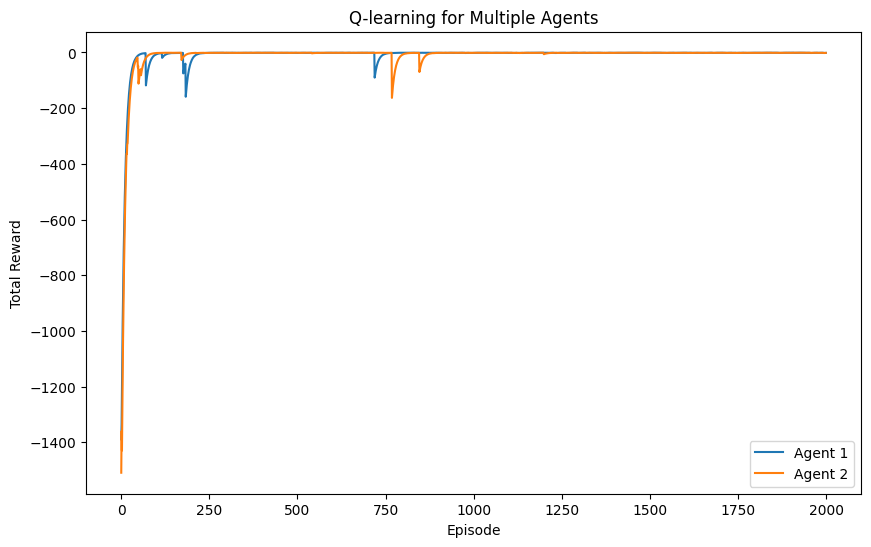

Plot saved as rewards.png
Q-table for Agent 1: {(3, 2): array([-1.98999999, -2.97009914, -2.97009705, -2.97009984, -1.        ]), (2, 2): array([-2.97009262, -3.93931606, -1.98999994, -3.94036156, -1.98999985]), (1, 2): array([ -3.93981497, -49.99999971,  -2.97009448,  -4.89286859,
        -2.96991611]), (0, 2): array([-49.99999991, -49.99999551,  -3.93921902,   0.        ,
         0.        ]), (4, 2): array([-2.97009382, -1.98999983, -3.93749088, -3.94033101, -1.98999948]), (2, 1): array([ -3.94032254,  -4.89772749,  -2.97009794, -53.90032704,
        -2.97009096]), (1, 1): array([ -4.88190874, -49.99999807,  -3.94031373, -54.82239118,
        -3.93926099]), (0, 1): array([-49.99999673, -49.99999964,  -4.89522906,   0.        ,
         0.        ]), (3, 1): array([ -2.97009473,  -3.94035623,  -3.94033539, -52.94036655,
        -1.98999998]), (2, 0): array([-53.90043195, -54.83524082, -52.94035507, -53.90030319,
        -3.94021617]), (1, 0): array([-54.83844536, -49.99999239, -53.8

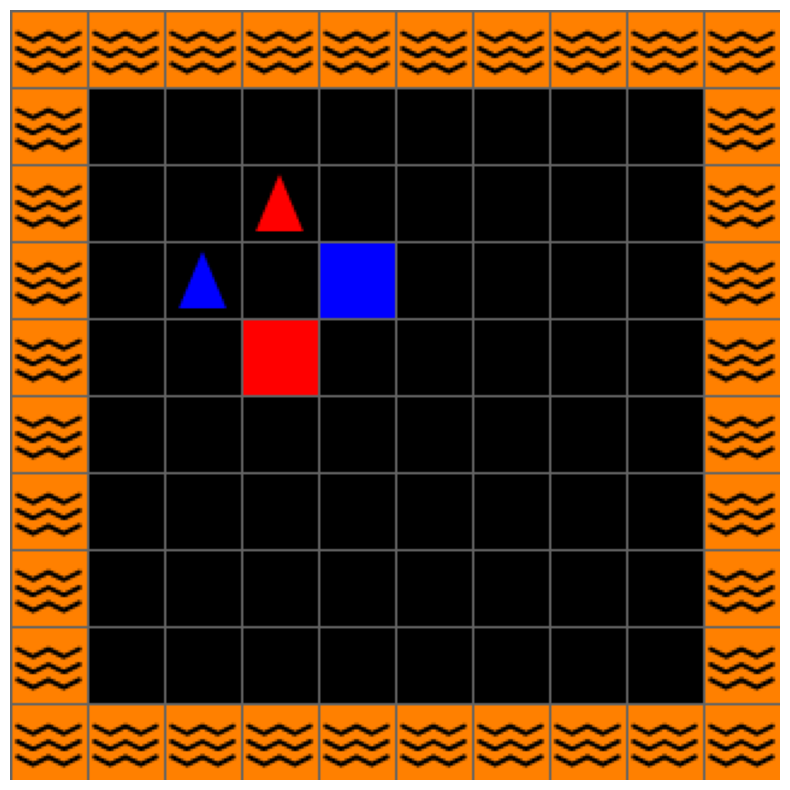


===== Initial Test Environment =====


In [16]:
import time
import os
import cv2
"""
Creates and trains agents with cyclic goals (each agent's goal is another agent's start position),
then tests them in a shared environment using the safety pipeline.

Args:
    num_agents: Number of agents to create
    width: Width of the grid environment
    height: Height of the grid environment
    training_episodes: Number of episodes for training each agent
    test_steps: Maximum number of steps to run the test
"""
# # Define agent positions in a cycle (each agent's goal is the next agent's position)
agent_positions = [(3,2),(2,3)]
                #    ,(5,6),(1,2)] # Rotate to create cycle with +1 to x coordinate
goal_positions = [(3,4),(4,3)]
                # (6,6),(1,1),(5,3)] # Rotate to create cycle with +1 to x coordinate
width =10
height = 10
# num_agents =4
# agent_positions, goal_positions = generate_random_positions(num_agents=num_agents, width=width, height=height, min_distance=2)

# Define some walls to make the environment more interesting
walls = [(i, 5) for i in range(3, 7)]

# Create training environment (separate environment for each agent)
train_env = MultiAgentEnvWrapper(
    is_testing=False,
    width=height,
    height=height,
    agent_positions=agent_positions,
    goal_positions=goal_positions,
    walls=walls
)

# Create and train agents
agents = []
for i in range(len(agent_positions)):
    print(f"\n===== Creating and training Agent {i+1} =====")
    agent = DynaQLearningAgent(state_dim=width*height, action_dim=5)
    agent.env_wrapper = train_env
    agent.agent_idx = i
    agents.append(agent)

# Train all agents independently
print("\n===== Training Agents =====")
training_episodes = 2000
all_rewards = train_all_agents(train_env, agents, num_episodes=training_episodes, max_steps=200)

# Plot training rewards
plot_rewards_for_all_agents(all_rewards)
Qstar = {}
# Copy Q-tables from all agents to a shared Q-table
# Create a structured dictionary to store Q-tables from all agents
for i, agent in enumerate(agents):
    Qstar[i] = agent.q_table.copy()  # Store each agent's Q-table separately
    print(f"Q-table for Agent {i+1}:", Qstar[i])
# Print sample Q-values from each agent's Q-table
for i in range(len(agents)):
    print(f"Agent {i+1} Q-values for position {agent_positions[i]}: {Qstar[i].get(agent_positions[i], 'Not found')}")
# Print Q-tables for all agents

# Create test environment (shared environment with all agents)
test_env = MultiAgentEnvWrapper(
    is_testing=True,
    width=width,
    height=height,
    agent_positions=agent_positions,
    goal_positions=goal_positions,
    walls=walls
)
test_env.visualize()
# Update agents to use the test environment
for i, agent in enumerate(agents):
    agent.env_wrapper = test_env

# Visualize initial state
print("\n===== Initial Test Environment =====")
obs, info = test_env.reset()





### Simulation

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from PIL import Image
import io

def run_and_record_safety_pipeline(test_env, agents, video_name="marl_simulation.mp4", max_steps=30, 
                                  k=3, L=200, safety_threshold=-2.0, Qstars=None):
    """
    Runs the safety pipeline for multi-agent reinforcement learning and saves the visualization as a video.
    
    Args:
        test_env (MultiAgentEnvWrapper): The test environment with all agents
        agents (list): List of agent objects
        video_name (str): Name of the output video file
        max_steps (int): Maximum number of steps to run the simulation
        k (int): Safety lookahead parameter for safety_aware_pipeline
        L (int): Learning iterations parameter for safety_aware_pipeline
        safety_threshold (float): Safety threshold for determining safe actions
        Qstars (dict): Dictionary of Q-tables for all agents
        
    Returns:
        str: Path to the saved video file
    """
    # Create videos directory if it doesn't exist
    videos_dir = os.path.expanduser("~/Desktop/Projet_MARL/toy_exeemple_normalized")
    os.makedirs(videos_dir, exist_ok=True)
    
    # Full path for video file
    video_path = os.path.join(videos_dir, video_name)
    Qstar = {}
    obs, info = test_env.reset()
    
    # Initialize frame collection
    frames = []
    
    figures={}
    # Add initial state to frames 
    mask=visualize_all_agents_planned_paths(test_env, agents, k_steps=k,Qstar=Qstar)
    # Get the grid image using your visualize method with show=False
    grid_img = test_env.visualize(show=False,highlight_masks=mask)
    
    # Create a figure with the initial state
    plt.figure(figsize=(10, 10))
    plt.imshow(grid_img)
    plt.title("Initial State", fontsize=14)
    plt.axis('off')
    plt.tight_layout()
  
    # Convert matplotlib figure to image
    canvas = FigureCanvas(plt.gcf())
    canvas.draw()
    initial_frame = np.array(canvas.renderer.buffer_rgba())
    plt.close()
    frames.append(initial_frame)
    Qsteps = {}
    # Run simulation with safety pipeline
    for step in range(max_steps):
        Qsteps[step] = {}
        figures[step] = {}
        # Run one step of the safety pipeline
        actions,safety_status,Qstep,figs =safety_aware_pipeline_with_safety_check(test_env, agents, k=k, L=L)
        for i, agent in enumerate(agents):
            Qstar[i] = agent.q_table.copy() 
        mask=visualize_all_agents_planned_paths(test_env, agents, k_steps=k,Qstar=Qstar)
        Qsteps[step] = Qstep
        figures[step] = figs
        # Check if all agents have reached their goals
        done = test_env.all_agents_at_goals()
        
        # Get the grid image using your visualize method with show=False
        grid_img = test_env.visualize(highlight_masks=mask,show=False)
        
        # Create a figure for this step
        plt.figure(figsize=(10, 10))
        plt.imshow(grid_img)
        plt.title(f"Step {step+1} | Actions: {actions} | Safety_status:{safety_status}", fontsize=14)
        plt.axis('off')
        plt.tight_layout()
        
        # Convert matplotlib figure to image
        canvas = FigureCanvas(plt.gcf())
        canvas.draw()
        frame = np.array(canvas.renderer.buffer_rgba())
        plt.close()
        frames.append(frame)
        
        # Report actions taken
        print(f"Actions taken: {actions}")
        
        # Check if simulation is complete
        if done:
            print(f"All agents reached their goals in {step+1} steps!")
            
            # Get the grid image for the final state
            grid_img = test_env.visualize(show=False)
            
            # Add a success message
            plt.figure(figsize=(10, 10))
            plt.imshow(grid_img)
            plt.title(f"Success! All agents reached goals in {step+1} steps", 
                     fontsize=18, color='green')
            plt.axis('off')
            plt.tight_layout()
            
            # Convert matplotlib figure to image
            canvas = FigureCanvas(plt.gcf())
            canvas.draw()
            success_frame = np.array(canvas.renderer.buffer_rgba())
            plt.close()
            frames.append(success_frame)
            break
    
    # Now create the video writer and write all frames
    # Determine frame size from the first frame
    height, width, _ = frames[0].shape
    
    # Create VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    video = cv2.VideoWriter(video_path, fourcc, 2, (width, height))  # 2 fps for easy viewing
    
    # Write frames to video
    for frame in frames:
        # Convert RGBA to BGR (OpenCV format)
        frame_bgr = cv2.cvtColor(frame, cv2.COLOR_RGBA2BGR)
        video.write(frame_bgr)
    
    # Release the video writer
    video.release()
    # Save figures for each agent at each step
    print(f"Video saved to: {video_path}")
    return video_path,Qsteps
# Run the simulation and save the video
video_path, Qstep = run_and_record_safety_pipeline(
    test_env, agents, video_name="marl_simulation.mp4", max_steps=30, 
    k=3, L=500, safety_threshold=-2.0, Qstars=Qstar
)

Qstep = flatten_qsteps(Qstep, k_value=3, L_value=500)

# Save Qsteps to a file
import pandas as pd
df = pd.DataFrame(Qstep)

# Extract the directory from video_path
videos_dir = os.path.dirname(video_path)

# Save the dataframe to CSV
csv_path = os.path.join(videos_dir, "Qsteps.csv")
df.to_csv(csv_path, index=False)
print(f"CSV file saved to: {csv_path}")


NameError: name 'visualize_all_agents_planned_paths' is not defined

In [34]:
def run_and_record_safety_pipeline(test_env, agents, video_name="marl_simulation.mp4", max_steps=30, 
                                  k=3, L=200, safety_threshold=-2.0, Qstars=None):
    # Create videos directory if it doesn't exist
    videos_dir = os.path.expanduser("~/Desktop/Projet_MARL/toy_exeemple_normalized")
    os.makedirs(videos_dir, exist_ok=True)
    
    # Full paths for video files
    main_video_path = os.path.join(videos_dir, video_name)
    qtable_video_name = "qtables_" + video_name
    qtable_video_path = os.path.join(videos_dir, qtable_video_name)
    
    # Reset environment
    obs, info = test_env.reset()
    
    # Initialize frame collections
    main_frames = []
    
    # Create a dictionary to store Q-table visualization frames for each agent
    qtable_frames = {i: [] for i in range(len(agents))}
    
    # Create initial Q-table visualizations for all agents
    for agent_idx in range(len(agents)):
        reachable_dict, reachable_set = compute_reachable_states(
            test_env, agent_idx=agent_idx, n_steps=k
        )
        unsafe_set_dict = K_agents_n_unsafe_set(
            test_env, agent_idx=agent_idx, n_steps=k, exclude_indices=None
        )
        
        fig = visualize_qtable_actions_with_unsafe_set(
            env=test_env,
            agent_idx=agent_idx,
            qtable=agents[agent_idx].q_table,
            reachable_set=reachable_set,
            unsafe_set_dict=unsafe_set_dict,
            show=False,
            title=f"Initial State - Agent {agent_idx+1}"
        )
        
        canvas = FigureCanvas(fig)
        canvas.draw()
        frame = np.array(canvas.renderer.buffer_rgba())
        qtable_frames[agent_idx].append(frame)
        plt.close(fig)
    
    # Add initial environment state to frames
    if Qstars is None:
        Qstar = {}
        for i, agent in enumerate(agents):
            Qstar[i] = agent.q_table.copy()
    else:
        Qstar = Qstars
        
    mask = visualize_all_agents_planned_paths(test_env, agents, k_steps=k, Qstar=Qstar)
    grid_img = test_env.visualize(show=False, highlight_masks=mask)
    
    plt.figure(figsize=(10, 10))
    plt.imshow(grid_img)
    plt.title("Initial State", fontsize=14)
    plt.axis('off')
    plt.tight_layout()
  
    canvas = FigureCanvas(plt.gcf())
    canvas.draw()
    initial_frame = np.array(canvas.renderer.buffer_rgba())
    plt.close()
    main_frames.append(initial_frame)
    
    Qsteps = {}
    
    # Run simulation with safety pipeline
    for step in range(max_steps):
        Qsteps[step] = {}
        
        # Run one step of the safety pipeline
        actions, safety_status, Qstep, step_figs = safety_aware_pipeline_with_safety_check(test_env, agents, k=k, L=L)
        
        # Update Qstar
        for i, agent in enumerate(agents):
            Qstar[i] = agent.q_table.copy()
        
        mask = visualize_all_agents_planned_paths(test_env, agents, k_steps=k, Qstar=Qstar)
        Qsteps[step] = Qstep
        
        # Process the figures for each agent
        for agent_idx in range(len(agents)):
            if agent_idx in step_figs and not safety_status[agent_idx]:
                # The agent needed safety intervention - use the horizon figures
                horizon_figs = step_figs[agent_idx]  # This should be a dict {k: fig, k-1: fig, ...}
                
                # Add each horizon's figure to the video
                sorted_horizons = sorted(horizon_figs.keys(), reverse=True)  # From k down to 1
                for horizon in sorted_horizons:
                    fig = horizon_figs[horizon]
                    canvas = FigureCanvas(fig)
                    canvas.draw()
                    frame = np.array(canvas.renderer.buffer_rgba())
                    qtable_frames[agent_idx].append(frame)
                    plt.close(fig)
            else:
                # The agent was already safe - create a new visualization
                reachable_dict, reachable_set = compute_reachable_states(
                    test_env, agent_idx=agent_idx, n_steps=k
                )
                unsafe_set_dict = K_agents_n_unsafe_set(
                    test_env, agent_idx=agent_idx, n_steps=k, exclude_indices=None
                )
                
                fig = visualize_qtable_actions_with_unsafe_set(
                    env=test_env,
                    agent_idx=agent_idx,
                    qtable=Qstar[agent_idx],
                    reachable_set=reachable_set,
                    unsafe_set_dict=unsafe_set_dict,
                    show=False,
                    title=f"Step {step+1} - Agent {agent_idx+1} (Safe) - Action: {actions[agent_idx]}"
                )
                
                canvas = FigureCanvas(fig)
                canvas.draw()
                frame = np.array(canvas.renderer.buffer_rgba())
                qtable_frames[agent_idx].append(frame)
                plt.close(fig)
        
        # Create the main environment visualization
        grid_img = test_env.visualize(highlight_masks=mask, show=False)
        
        plt.figure(figsize=(10, 10))
        plt.imshow(grid_img)
        plt.title(f"Step {step+1} | Actions: {actions} | Safety_status: {safety_status}", fontsize=14)
        plt.axis('off')
        plt.tight_layout()
        
        canvas = FigureCanvas(plt.gcf())
        canvas.draw()
        frame = np.array(canvas.renderer.buffer_rgba())
        plt.close()
        main_frames.append(frame)
        
        print(f"Actions taken: {actions}")
        
        # Check if simulation is complete
        done = test_env.all_agents_at_goals()
        if done:
            print(f"All agents reached their goals in {step+1} steps!")
            
            grid_img = test_env.visualize(show=False)
            
            plt.figure(figsize=(10, 10))
            plt.imshow(grid_img)
            plt.title(f"Success! All agents reached goals in {step+1} steps", 
                     fontsize=18, color='green')
            plt.axis('off')
            plt.tight_layout()
            
            canvas = FigureCanvas(plt.gcf())
            canvas.draw()
            success_frame = np.array(canvas.renderer.buffer_rgba())
            plt.close()
            main_frames.append(success_frame)
            break
    
    # Create the main video
    height, width, _ = main_frames[0].shape
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    main_video = cv2.VideoWriter(main_video_path, fourcc, 2, (width, height))
    
    for frame in main_frames:
        frame_bgr = cv2.cvtColor(frame, cv2.COLOR_RGBA2BGR)
        main_video.write(frame_bgr)
    
    main_video.release()
    print(f"Main video saved to: {main_video_path}")
    
    # Create the Q-table video with agent-by-agent progression
    if any(frames for frames in qtable_frames.values()):
        sample_frame = next(frame for frames in qtable_frames.values() for frame in frames if len(frames) > 0)
        q_height, q_width, _ = sample_frame.shape
        
        qtable_video = cv2.VideoWriter(qtable_video_path, fourcc, 1, (q_width, q_height))
        
        # Create title frame
        plt.figure(figsize=(12, 10))
        plt.text(0.5, 0.5, "Q-Table Evolution by Agent", 
                ha="center", va="center", fontsize=24, fontweight="bold")
        plt.axis("off")
        canvas = FigureCanvas(plt.gcf())
        canvas.draw()
        title_frame = np.array(canvas.renderer.buffer_rgba())
        title_frame_bgr = cv2.cvtColor(title_frame, cv2.COLOR_RGBA2BGR)
        title_frame_resized = cv2.resize(title_frame_bgr, (q_width, q_height))
        plt.close()
        
        # Add title frame to video (2 seconds)
        for _ in range(2):
            qtable_video.write(title_frame_resized)
        
        # For each agent, add their Q-table frames
        for agent_idx in range(len(agents)):
            if len(qtable_frames[agent_idx]) > 0:
                # Add agent title slide
                plt.figure(figsize=(12, 10))
                plt.text(0.5, 0.5, f"Agent {agent_idx+1} Q-Table Evolution", 
                        ha="center", va="center", fontsize=24, fontweight="bold")
                plt.axis("off")
                canvas = FigureCanvas(plt.gcf())
                canvas.draw()
                agent_title = np.array(canvas.renderer.buffer_rgba())
                agent_title_bgr = cv2.cvtColor(agent_title, cv2.COLOR_RGBA2BGR)
                agent_title_resized = cv2.resize(agent_title_bgr, (q_width, q_height))
                plt.close()
                
                # Add agent title to video (2 seconds)
                for _ in range(2):
                    qtable_video.write(agent_title_resized)
                
                # Add all frames for this agent
                for frame in qtable_frames[agent_idx]:
                    frame_bgr = cv2.cvtColor(frame, cv2.COLOR_RGBA2BGR)
                    qtable_video.write(frame_bgr)
                
                # Add a separator frame if not the last agent
                if agent_idx < len(agents) - 1:
                    separator = np.ones((q_height, q_width, 3), dtype=np.uint8) * 255
                    qtable_video.write(separator)
        
        qtable_video.release()
        print(f"Q-table video saved to: {qtable_video_path}")
    
    return main_video_path, qtable_video_path, Qsteps

main_video_path,qtable_video_path,Qsteps=run_and_record_safety_pipeline(
    test_env, agents, video_name="marl_simulation.mp4", max_steps=30, 
    k=3, L=500, safety_threshold=-2.0, Qstars=Qstar)

Planned path for Agent 1: [(3, 2), (np.int64(3), np.int64(3)), (np.int64(3), np.int64(4))]
Planned path for Agent 2: [(2, 3), (np.int64(3), np.int64(3)), (np.int64(4), np.int64(3))]


TypeError: visualize_qtable_actions_with_unsafe_set() got multiple values for argument 'agent_idx'

In [26]:
def select_action_with_qtable(qtable, state, action_dim=5):
    """
    Select the best action based on the provided Q-table.
    
    Args:
        qtable: The Q-table dictionary
        state: The current state (position)
        action_dim: Number of possible actions
        
    Returns:
        int: The best action according to the Q-table
    """
    state_key = tuple(state) if isinstance(state, np.ndarray) else state
    
    if state_key in qtable:
        return np.argmax(qtable[state_key])
    else:
        # If state not in Q-table, return default action
        return 0  # Default: stay in place

def n_steps_safety_judger_qtable(n_steps, env, agents, safety_threshold=-40.0, Qstars=None):
    """
    Evaluates if agent trajectories over n steps are safe using Q-tables.
    
    Args:
        n_steps: Number of steps to look ahead
        env: Environment wrapper
        agents: List of agent objects with Q-tables
        safety_threshold: Reward threshold to judge safety
        Qstars: Optional Q-tables to use instead of agents' Q-tables
        
    Returns:
        numpy.ndarray: Boolean array indicating if each agent is safe
    """
    judge = np.ones(len(agents), dtype=bool)  # Initialize to True for all agents
    
    # Get current positions of all agents
    current_positions = [env.get_agent_position(idx=i) for i in range(len(agents))]
    next_positions = current_positions.copy()

    # Forecast for each agent over n steps and check safety
    for agent_idx in range(len(agents)):
        current_state = next_positions[agent_idx]
        
        if Qstars is None or Qstars[agent_idx] is None:
            qtable = agents[agent_idx].q_table
        else:
            qtable = Qstars[agent_idx]
        # Simulate n steps for this agent
        for step in range(n_steps):
            # Select action using the provided Q-table
            action = select_action_with_qtable(qtable, current_state)
            
            # Use model to simulate action and get reward
            reward, next_state, _ = model(env, agent_idx, current_state, action)
            
            # If reward is below safety threshold, agent is not safe
            if reward <= safety_threshold:
                judge[agent_idx] = False
                break  # No need to continue for this agent
                
            current_state = next_state  # Update state for next step
        
        # Update final position after n steps
        next_positions[agent_idx] = current_state
    
    return judge

def visualize_agent_planned_path_qtable(env, agent_idx, qtable, k_steps=5, fixed_color=None):
    """
    Creates a highlight mask showing the planned path for an agent over k steps using Q-table.
    
    Args:
        env: The environment wrapper
        agent_idx: Index of the agent
        qtable: Q-table to use for action selection
        k_steps: Number of steps to look ahead
        fixed_color: Optional color index to use for path visualization
        
    Returns:
        np.ndarray: A highlight mask showing the planned path
    """
    # Create a 2D array of lists for the highlight mask
    mask = np.empty((env.width, env.height), dtype=object)
    for i in range(env.width):
        for j in range(env.height):
            mask[i, j] = []
    
    # Get the agent's current position
    current_pos = env.get_agent_position(idx=agent_idx)
    
    # Get reference to the world object for colors
    env_world = env.envs[0].world
    color_count = len(env_world.IDX_TO_COLOR)
    
    # Add the current position to the path with step 0
    x, y = current_pos
    step_color = 0 if fixed_color is None else fixed_color
    mask[x, y].append(step_color)
    
    # Simulate the agent's path for k steps
    simulated_pos = current_pos
    path = [current_pos]
    
    for step in range(k_steps):
        # Select action according to the provided Q-table
        action = select_action_with_qtable(qtable, simulated_pos)
        
        # Simulate the action
        next_pos = model_state(simulated_pos, action)
        
        # Check if next position is within bounds
        x, y = next_pos
        if 0 <= x < env.width and 0 <= y < env.height:
            step_color = (step+1) % color_count if fixed_color is None else fixed_color
            mask[x, y].append(step_color)
            
            # Update for next iteration
            simulated_pos = next_pos
            path.append(next_pos)
        else:
            # Position out of bounds, stop simulating
            print(f"Agent {agent_idx+1} would go out of bounds at step {step+1}.")
            break
        
        # Break if the agent reaches its goal
        if next_pos == env.get_agent_goal(idx=agent_idx):
            break
    
    print(f"Planned path for Agent {agent_idx+1}: {path}")
    return mask

def visualize_all_agents_planned_paths(env, agents, k_steps=5, Qstar=None):
    """
    Creates a merged highlight mask showing the planned paths for all agents.
    
    Args:
        env: The environment wrapper
        agents: List of agent objects with Q-tables
        k_steps: Number of steps to look ahead
        Qstar: Optional list of Q-tables to use instead of agents' Q-tables
        
    Returns:
        np.ndarray: A highlight mask showing all planned paths
    """
    # Create a 2D array of lists for the combined highlight mask
    combined_mask = np.empty((env.width, env.height), dtype=object)
    for i in range(env.width):
        for j in range(env.height):
            combined_mask[i, j] = []
    
    # Generate path for each agent and add to the combined mask
    for agent_idx in range(len(agents)):
        # Use visualize_agent_planned_path_qtable for each agent
        if Qstar is not None and agent_idx < len(Qstar) and Qstar[agent_idx] is not None:
            qtable = Qstar[agent_idx]
        else:
            qtable = agents[agent_idx].q_table
                    
        # Get agent's mask with a fixed color (the agent's index)
        agent_mask = visualize_agent_planned_path_qtable(
            env, 
            agent_idx, 
            qtable, 
            k_steps=k_steps, 
            fixed_color=agent_idx % len(env.envs[0].world.IDX_TO_COLOR)
        )
        
        # Merge the agent's mask with the combined mask
        for i in range(env.width):
            for j in range(env.height):
                if agent_mask[i, j]:
                    combined_mask[i, j].extend(agent_mask[i, j])
    
    return combined_mask

def flatten_qsteps(qsteps, k_value=None, L_value=None):
    """
    Aplatit la structure hiérarchique de Qsteps en lignes pour DataFrame,
    en déterminant automatiquement quelle position est le centre (agent) 
    et quelles positions sont up, down, left, right.
    
    Args:
        qsteps: Le dictionnaire hiérarchique à aplatir
        k_value: La valeur de k (horizon maximum) utilisée
        L_value: La valeur de L (itérations) utilisée
    
    Returns:
        list: Liste de dictionnaires, chaque dictionnaire représentant une ligne
    """
    rows = []
    
    for step, agents_dict in qsteps.items():
        if not agents_dict:  # Skip empty dictionaries
            continue
            
        for agent_idx, horizons_dict in agents_dict.items():
            if not horizons_dict:  # Skip empty dictionaries
                continue
                
            # Trier les horizons dans l'ordre croissant
            sorted_horizons = sorted(horizons_dict.keys(), reverse=False)
            
            for horizon in sorted_horizons:
                qtable = horizons_dict[horizon]
                if not qtable or len(qtable) == 0:  # Skip empty dictionaries
                    continue
                
                # Convertir tous les états en tuples d'entiers simples
                states = []
                for state in qtable.keys():
                    clean_state = tuple(int(x) for x in state)
                    states.append(clean_state)
                
                if len(states) == 0:
                    continue
                    
                # Trouver la position de l'agent (centre) et les positions adjacentes
                # On suppose que le centre est la position qui a des voisins dans les 4 directions
                positions = {'center': None, 'up': None, 'down': None, 'left': None, 'right': None}
                
                # Si nous avons exactement 5 états, nous pouvons déterminer directement le centre
                if len(states) == 5:
                    # Pour chaque état potentiel au centre
                    for state in states:
                        # Vérifier si les 4 directions adjacentes sont présentes
                        up = (state[0], state[1] - 1)
                        down = (state[0], state[1] + 1)
                        left = (state[0] - 1, state[1])
                        right = (state[0] + 1, state[1])
                        
                        if up in states and down in states and left in states and right in states:
                            positions['center'] = state
                            positions['up'] = up
                            positions['down'] = down
                            positions['left'] = left
                            positions['right'] = right
                            break
                
                # Si nous n'avons pas trouvé le centre avec la méthode précédente
                # Cela peut arriver si certains états sont bloqués par des murs
                if positions['center'] is None and len(states) > 0:
                    # Alternative: trouver le "centre" comme étant l'état avec le plus de voisins
                    neighbor_counts = {}
                    for state in states:
                        neighbors = [
                            (state[0], state[1] - 1),  # up
                            (state[0], state[1] + 1),  # down
                            (state[0] - 1, state[1]),  # left
                            (state[0] + 1, state[1])   # right
                        ]
                        count = sum(1 for n in neighbors if n in states)
                        neighbor_counts[state] = count
                    
                    # L'état avec le plus de voisins est probablement le centre
                    center = max(neighbor_counts.items(), key=lambda x: x[1])[0]
                    positions['center'] = center
                    
                    # Déterminer les positions adjacentes présentes
                    up = (center[0], center[1] - 1)
                    down = (center[0], center[1] + 1)
                    left = (center[0] - 1, center[1])
                    right = (center[0] + 1, center[1])
                    
                    positions['up'] = up if up in states else None
                    positions['down'] = down if down in states else None
                    positions['left'] = left if left in states else None
                    positions['right'] = right if right in states else None
                
                # Créer une ligne pour cette configuration
                row = {
                    'k': k_value,
                    'L': L_value,
                    'Step': step,
                    'Agent': agent_idx,
                    'Horizon': "original qtable" if horizon == k_value + 1 else horizon,
                }
                
                # Ajouter le s états et leurs valeurs Q
                for pos_name, pos in positions.items():
                    if pos is not None:
                        row[f'{pos_name}_Position'] = pos
                        q_values = qtable[pos]
                        row[f'{pos_name}_Q'] = q_values
                        row[f'{pos_name}_BestAction'] = np.argmax(q_values)
                
                rows.append(row)
    
    return rows




===== Running with k=1, L=1 =====
Running simulation with k=1, L=1...
Planned path for Agent 1: [(3, 2), (np.int64(3), np.int64(3))]
Planned path for Agent 2: [(2, 3), (np.int64(3), np.int64(3))]
Planned path for Agent 1: [(3, 2), (np.int64(3), np.int64(3))]
Planned path for Agent 2: [(2, 3), (np.int64(3), np.int64(3))]
Actions taken: [0, 0]
Planned path for Agent 1: [(3, 2), (np.int64(3), np.int64(3))]
Planned path for Agent 2: [(2, 3), (np.int64(3), np.int64(3))]
Actions taken: [0, 0]
Planned path for Agent 1: [(3, 2), (np.int64(3), np.int64(3))]
Planned path for Agent 2: [(2, 3), (2, 3)]
Actions taken: [0, np.int64(0)]
Planned path for Agent 1: [(3, 1), (np.int64(3), np.int64(2))]
Planned path for Agent 2: [(2, 3), (2, 3)]
Actions taken: [np.int64(3), np.int64(0)]
Planned path for Agent 1: [(3, 2), (np.int64(3), np.int64(1))]
Planned path for Agent 2: [(2, 3), (2, 3)]
Actions taken: [np.int64(4), np.int64(0)]
Planned path for Agent 1: [(3, 1), (np.int64(3), np.int64(2))]
Planned p

KeyboardInterrupt: 

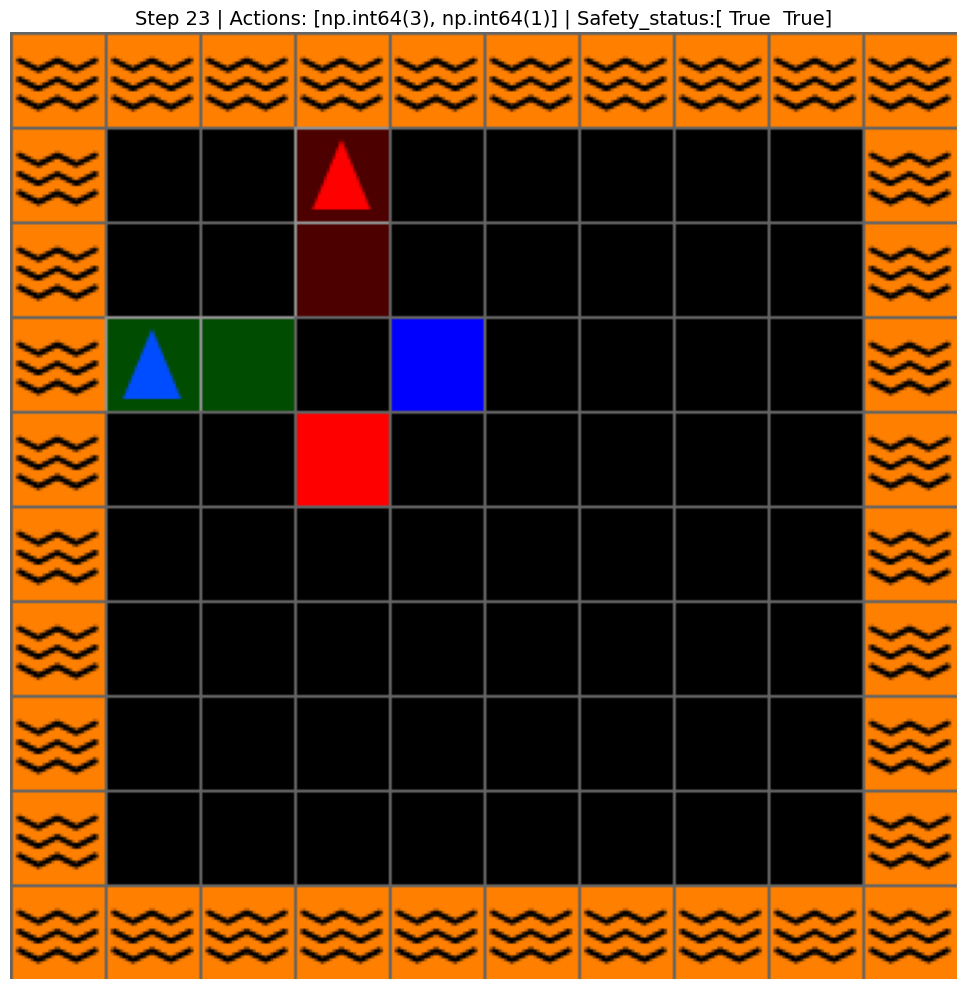

In [ ]:
import numpy as np
import pandas as pd
import os
import time
from itertools import product
def flatten_qsteps(qsteps, k_value=None, L_value=None):
    """
    Aplatit la structure hiérarchique de Qsteps en lignes pour DataFrame,
    en déterminant automatiquement quelle position est le centre (agent) 
    et quelles positions sont up, down, left, right.
    
    Args:
        qsteps: Le dictionnaire hiérarchique à aplatir
        k_value: La valeur de k (horizon maximum) utilisée
        L_value: La valeur de L (itérations) utilisée
    
    Returns:
        list: Liste de dictionnaires, chaque dictionnaire représentant une ligne
    """
    rows = []
    
    for step, agents_dict in qsteps.items():
        if not agents_dict:  # Skip empty dictionaries
            continue
            
        for agent_idx, horizons_dict in agents_dict.items():
            if not horizons_dict:  # Skip empty dictionaries
                continue
                
            # Trier les horizons dans l'ordre croissant
            sorted_horizons = sorted(horizons_dict.keys(), reverse=False)
            
            for horizon in sorted_horizons:
                qtable = horizons_dict[horizon]
                if not qtable or len(qtable) == 0:  # Skip empty dictionaries
                    continue
                
                # Convertir tous les états en tuples d'entiers simples
                states = []
                for state in qtable.keys():
                    clean_state = tuple(int(x) for x in state)
                    states.append(clean_state)
                
                if len(states) == 0:
                    continue
                    
                # Trouver la position de l'agent (centre) et les positions adjacentes
                # On suppose que le centre est la position qui a des voisins dans les 4 directions
                positions = {'center': None, 'up': None, 'down': None, 'left': None, 'right': None}
                
                # Si nous avons exactement 5 états, nous pouvons déterminer directement le centre
                if len(states) == 5:
                    # Pour chaque état potentiel au centre
                    for state in states:
                        # Vérifier si les 4 directions adjacentes sont présentes
                        up = (state[0], state[1] - 1)
                        down = (state[0], state[1] + 1)
                        left = (state[0] - 1, state[1])
                        right = (state[0] + 1, state[1])
                        
                        if up in states and down in states and left in states and right in states:
                            positions['center'] = state
                            positions['up'] = up
                            positions['down'] = down
                            positions['left'] = left
                            positions['right'] = right
                            break
                
                # Si nous n'avons pas trouvé le centre avec la méthode précédente
                # Cela peut arriver si certains états sont bloqués par des murs
                if positions['center'] is None and len(states) > 0:
                    # Alternative: trouver le "centre" comme étant l'état avec le plus de voisins
                    neighbor_counts = {}
                    for state in states:
                        neighbors = [
                            (state[0], state[1] - 1),  # up
                            (state[0], state[1] + 1),  # down
                            (state[0] - 1, state[1]),  # left
                            (state[0] + 1, state[1])   # right
                        ]
                        count = sum(1 for n in neighbors if n in states)
                        neighbor_counts[state] = count
                    
                    # L'état avec le plus de voisins est probablement le centre
                    center = max(neighbor_counts.items(), key=lambda x: x[1])[0]
                    positions['center'] = center
                    
                    # Déterminer les positions adjacentes présentes
                    up = (center[0], center[1] - 1)
                    down = (center[0], center[1] + 1)
                    left = (center[0] - 1, center[1])
                    right = (center[0] + 1, center[1])
                    
                    positions['up'] = up if up in states else None
                    positions['down'] = down if down in states else None
                    positions['left'] = left if left in states else None
                    positions['right'] = right if right in states else None
                
                # Créer une ligne pour cette configuration
                row = {
                    'k': k_value,
                    'L': L_value,
                    'Step': step,
                    'Agent': agent_idx,
                    'Horizon': "original qtable" if horizon == k_value + 1 else horizon,
                }
                
                # Ajouter le s états et leurs valeurs Q
                for pos_name, pos in positions.items():
                    if pos is not None:
                        row[f'{pos_name}_Position'] = pos
                        q_values = qtable[pos]
                        row[f'{pos_name}_Q'] = q_values
                        row[f'{pos_name}_BestAction'] = np.argmax(q_values)
                
                rows.append(row)
    
    return rows
# Définir les plages de valeurs pour L et k
L_values = [1,5,10 ,15,20,50,100,200]
k_values = [1,2]

# Créer un dossier pour les résultats si nécessaire
results_dir = os.path.expanduser("~/Desktop/Projet_MARL/toy_exeemple_normalized")
os.makedirs(results_dir, exist_ok=True)

# Liste pour collecter toutes les données pour CSV
all_rows = []

# Exécuter la simulation pour chaque combinaison de paramètres
for k, L in product(k_values, L_values):
    print(f"\n\n===== Running with k={k}, L={L} =====")
    
    # Créer un nom de fichier vidéo basé sur les paramètres
    video_name = f"easy_ex_k{k}_L{L}.mp4"
    
    # Réinitialiser l'environnement de test et les agents pour une nouvelle exécution
    test_env = MultiAgentEnvWrapper(
        is_testing=True,
        width=width,
        height=height,
        agent_positions=agent_positions,
        goal_positions=goal_positions,
        walls=walls
    )
    
    # Mettre à jour les agents avec l'environnement de test réinitialisé
    for i, agent in enumerate(agents):
        agent.env_wrapper = test_env
        # Restaurer la Q-table originale pour chaque agent
        agent.q_table = Qstar[i].copy()
    
    # Lancer la simulation avec cette combinaison de paramètres
    print(f"Running simulation with k={k}, L={L}...")
    video_path, Qsteps = run_and_record_safety_pipeline(
        test_env, agents, 
        video_name=video_name, 
        max_steps=40,
        k=k, 
        L=L, 
        safety_threshold=-2.0, 
        Qstars=Qstar
    )
    
    # Aplatir les données de Qsteps avec les valeurs de k et L
    flattened_data = flatten_qsteps(Qsteps, k_value=k, L_value=L)
    
    # Ajouter les données à la liste complète
    all_rows.extend(flattened_data)
    
    # Sauvegarder les données pour cette combinaison de paramètres
    df_current = pd.DataFrame(flattened_data)
    if not df_current.empty:
        df_current.to_csv(os.path.join(results_dir, f"qsteps_k{k}_L{L}.csv"), index=False)
        print(f"CSV saved for k={k}, L={L}")

# Créer un DataFrame avec toutes les données
df_all = pd.DataFrame(all_rows)

# Sauvegarder le CSV combiné
combined_csv_path = os.path.join(results_dir, "all_parameters_qsteps.csv")
df_all.to_csv(combined_csv_path, index=False)

print(f"\nCombined CSV with all parameters saved to: {combined_csv_path}")

In [35]:
def visualize_qtable_actions_with_unsafe_set(env, agent_idx, qtable, reachable_set, unsafe_set_dict, 
                                            show=True, title=None, figsize=(12, 10)):
    """
    Creates a visualization that shows:
    1. The preferred action for each state in the reachable set according to a Q-table
    2. Unsafe states for the agent
    3. Positions of other agents and agent goals
    
    Args:
        env: The environment wrapper
        agent_idx: Index of the agent to visualize
        qtable: Q-table dictionary of the agent
        reachable_set: Set of reachable states for the agent
        unsafe_set_dict: Dictionary of unsafe states for the agent
        show: Whether to display the plot (True) or just return the figure (False)
        title: Optional title for the plot
        figsize: Size of the figure as tuple (width, height)
        
    Returns:
        matplotlib.figure.Figure: The figure object
    """
    import matplotlib.pyplot as plt
    import numpy as np
    from matplotlib.patches import Arrow, Rectangle, Circle
    from matplotlib.colors import LinearSegmentedColormap
    
    # Create figure and axis
    fig, ax = plt.subplots(figsize=figsize)
    
    # Set up the grid
    width = env.width
    height = env.height
    
    # Create a grid
    ax.set_xlim(-0.5, width-0.5)
    ax.set_ylim(-0.5, height-0.5)
    ax.set_xticks(np.arange(-0.5, width, 1))
    ax.set_yticks(np.arange(-0.5, height, 1))
    ax.grid(color='black', linestyle='-', linewidth=1)
    
    # Define colors
    action_colors = {
        0: 'gray',      # Stay - Gray
        1: 'blue',      # Left - Blue
        2: 'black',       # Right - Red
        3: 'green',     # Up - Green
        4: 'orange'     # Down - Orange
    }
    
    # Create a custom colormap for unsafe areas with transparency
    unsafe_cmap = LinearSegmentedColormap.from_list('unsafe', [(1, 0, 0, 0.1), (1, 0, 0, 0.5)], N=10)
    
    # Add background color to all grid cells
    for x in range(width):
        for y in range(height):
            ax.add_patch(Rectangle((x-0.5, y-0.5), 1, 1, fill=True, color='white', alpha=0.2))
    
    # Visualize unsafe set with varying transparency based on count
    max_count = 1
    all_unsafe_positions = set()
    for step, positions_with_counts in unsafe_set_dict.items():
        all_unsafe_positions.update(positions_with_counts.keys())
        max_count = max(max_count, max(positions_with_counts.values()) if positions_with_counts else 1)
    
    for pos in all_unsafe_positions:
        x, y = pos
        if 0 <= x < width and 0 <= y < height:
            # Find maximum count for this position across all steps
            max_pos_count = max([unsafe_set_dict[step].get(pos, 0) for step in unsafe_set_dict])
            alpha = 0.3 + 0.5 * (max_pos_count / max_count)
            ax.add_patch(Rectangle((x-0.5, y-0.5), 1, 1, fill=True, color='red', alpha=alpha))
            ax.text(x, y, f"U:{max_pos_count}", ha='center', va='center', fontsize=9, color='black')
    
    # Draw arrows for best actions at reachable states
    arrow_props = dict(arrowstyle='->', linewidth=2)
    for pos in reachable_set:
        x, y = pos
        if pos in qtable:
            action = np.argmax(qtable[pos])
            q_value = qtable[pos][action]
            
            # Calculate arrow direction
            dx, dy = 0, 0
            if action == 1:  # Left
                dx = -0.3
            elif action == 2:  # Right
                dx = 0.3
            elif action == 3:  # Up
                dy = -0.3
            elif action == 4:  # Down
                dy = 0.3
            
            if action != 0:  # Draw arrow if not "stay" action
                ax.add_patch(Arrow(x, y, dx, dy, width=0.2, color=action_colors[action]))
            else:  # Draw circle for "stay" action
                ax.add_patch(Circle((x, y), 0.2, color=action_colors[action], alpha=0.7))
            
            # Add the Q-value text
            ax.text(x+0.25, y+0.25, f"{q_value:.2f}", ha='center', va='center', fontsize=7,
                   bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
    
    # Add current agent position with a distinct marker
    agent_pos = env.get_agent_position(idx=agent_idx)
    agent_goal = env.get_agent_goal(idx=agent_idx)
    
    ax.plot(agent_pos[0], agent_pos[1], 'o', markersize=15, color='purple', alpha=0.7)
    ax.text(agent_pos[0], agent_pos[1], f"A{agent_idx}", ha='center', va='center', color='white', fontweight='bold')
    
    # Add agent goal with a star marker
    ax.plot(agent_goal[0], agent_goal[1], '*', markersize=18, color='green', alpha=0.7)
    ax.text(agent_goal[0], agent_goal[1], f"G{agent_idx}", ha='center', va='center', color='white', fontweight='bold')
    
    # Add other agents positions with different markers
    if env.is_testing:
        num_agents = len(env.envs[0].agents)
    else:
        num_agents = len(env.envs)
    
    for other_idx in range(num_agents):
        if other_idx != agent_idx:
            other_pos = env.get_agent_position(idx=other_idx)
            other_goal = env.get_agent_goal(idx=other_idx)
            
            ax.plot(other_pos[0], other_pos[1], 's', markersize=12, color='blue', alpha=0.7)
            ax.text(other_pos[0], other_pos[1], f"A{other_idx}", ha='center', va='center', color='white')
            
            ax.plot(other_goal[0], other_goal[1], 'p', markersize=12, color='darkgreen', alpha=0.7)
            ax.text(other_goal[0], other_goal[1], f"G{other_idx}", ha='center', va='center', color='white')
    
    # Add legend
    legend_elements = [
        Rectangle((0, 0), 1, 1, color='red', alpha=0.3, label='Unsafe States'),
        Circle((0, 0), 0.2, color=action_colors[0], alpha=0.7, label='Stay'),
        Arrow(0, 0, 0.3, 0, width=0.2, color=action_colors[2], label='Right'),
        Arrow(0, 0, -0.3, 0, width=0.2, color=action_colors[1], label='Left'),
        Arrow(0, 0, 0, 0.3, width=0.2, color=action_colors[3], label='Up'),
        Arrow(0, 0, 0, -0.3, width=0.2, color=action_colors[4], label='Down'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='purple', markersize=10, label=f'Agent {agent_idx}'),
        plt.Line2D([0], [0], marker='s', color='w', markerfacecolor='blue', markersize=10, label='Other Agents'),
        plt.Line2D([0], [0], marker='*', color='w', markerfacecolor='green', markersize=10, label=f'Goal {agent_idx}'),
        plt.Line2D([0], [0], marker='p', color='w', markerfacecolor='darkgreen', markersize=10, label='Other Goals')
    ]
    
    ax.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, 1.05), 
              ncol=5, fancybox=True, shadow=True)
    
    # Flip y-axis to match the environment's coordinates
    ax.set_ylim(ax.get_ylim()[::-1])
    
    # Set title
    if title is None:
        title = f"Agent {agent_idx} - Q-Table Actions and Unsafe States"
    ax.set_title(title)
    
    # Show plot if requested
    if show:
        plt.tight_layout()
        plt.show()
    
    return fig

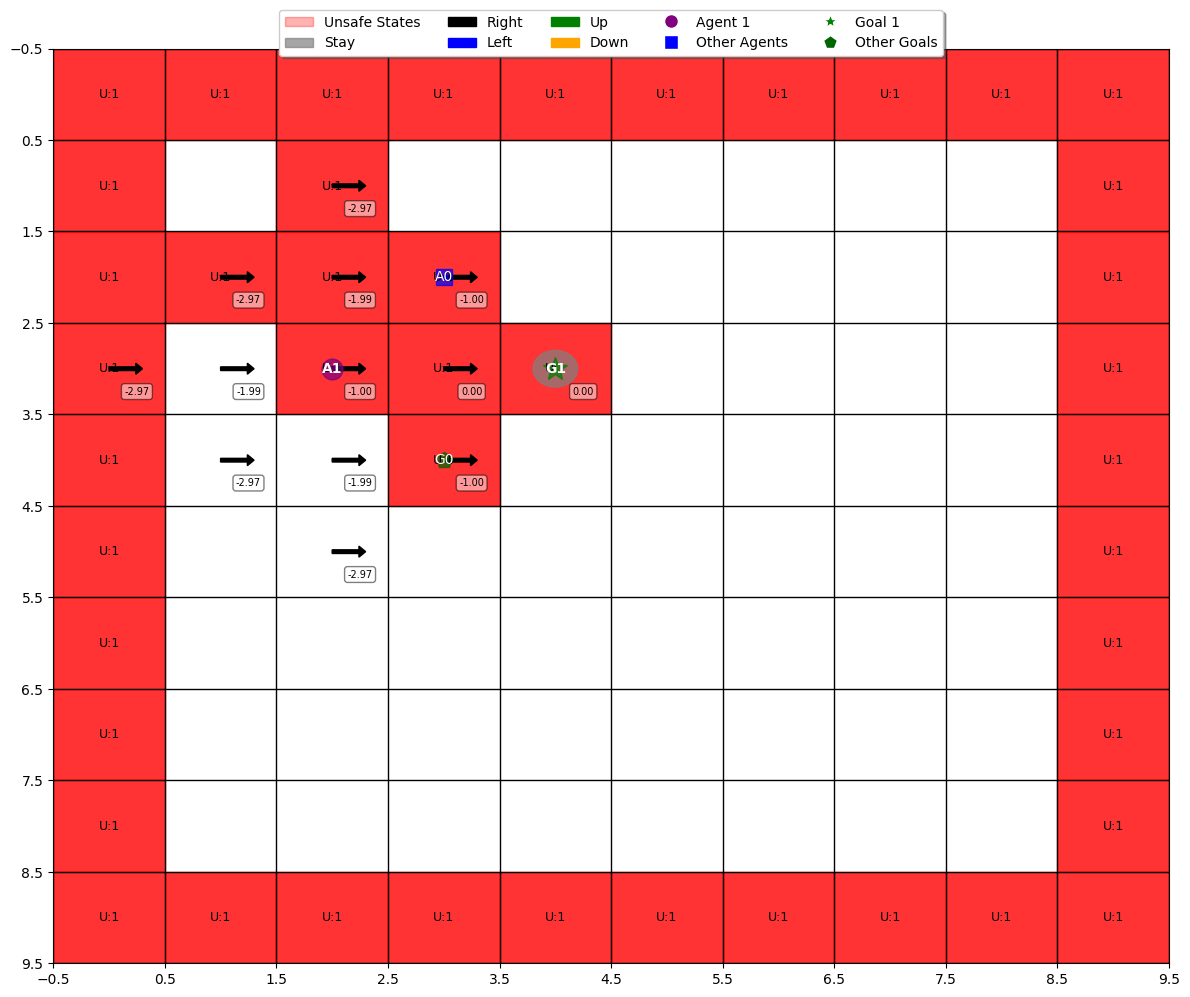

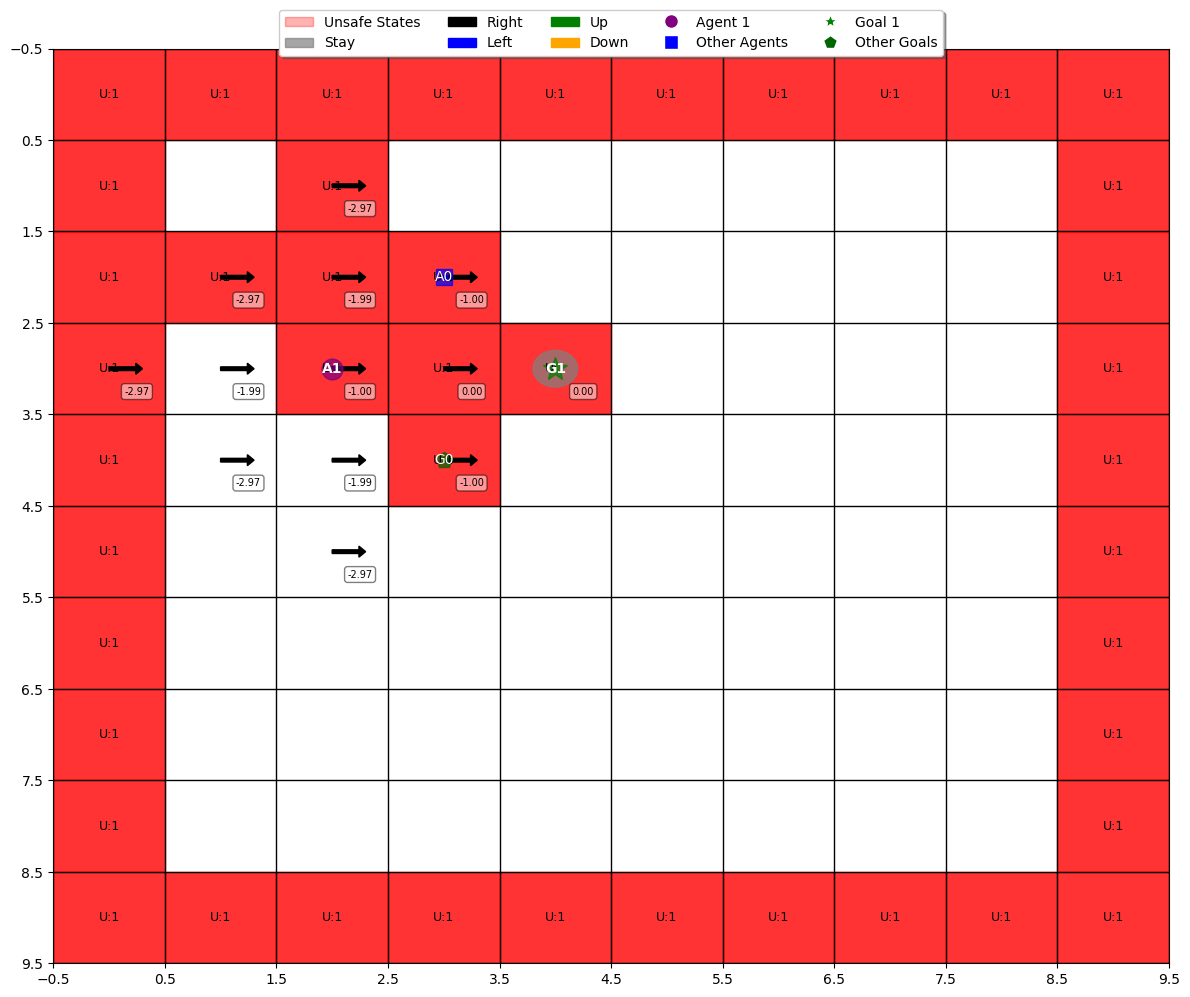

In [25]:
# Example usage of the visualization function
def example_visualization(env, agents, agent_idx=1, k_steps=2):
    # Get the agent's Q-table
    qtable = agents[agent_idx].q_table
    
    # Get reachable states for the agent
    reachable_dict, reachable_set = compute_reachable_states(
        env, agent_idx=agent_idx, n_steps=k_steps
    )
    
    # Get unsafe set dictionary
    unsafe_set_dict = K_agents_n_unsafe_set(
        env, agent_idx=agent_idx, n_steps=k_steps, exclude_indices=None
    )
    
    # Create the visualization
    fig = visualize_qtable_actions_with_unsafe_set(
        env=env,
        agent_idx=agent_idx,
        qtable=qtable,
        reachable_set=reachable_set,
        unsafe_set_dict=unsafe_set_dict,
        title=f"Agent {agent_idx} Planning with k={k_steps}"
    )
    
    return fig

# You can call this function in your notebook:
example_visualization(test_env, agents, agent_idx=1, k_steps=2)